# Evaluating Model Performance
This notebook will be used to evaluate each of the models' testing accuracies, based on what N_MATCHES is. We will run this analysis on the models before and after they were tuned, so we can visualize the impact of tuning hyperparameters. This will also help us explore the relationship between how many previous matches are used for calculating form metrics and a model's accuracy.

In [1]:
import os
import sys
from pathlib import Path

# Get current file path and change the working directory to the project root
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

import copy
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier

from src.config import Models
from src.data.build_features import build_rolling_features
from src.data.split import chrono_split
from src.models.train_model import train
from src.util.DFImputer import DFImputer
from src.util.notebook_utils import get_data_only

### Define Pre-Tuning Parameters
In this section, we'll evaluate the accuracies of the models before their hyperparameters were tuned. Our pretuned models were the models found in the previous notebook's param_grids "model" objects. The post-tuned models are simply found in src/.

In [2]:
pre_tuned_models = {    
    Models.LOGISTIC_REGRESSION: 
        Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                solver="lbfgs",
                max_iter=5000
            ))
        ]),

    Models.XGBOOST:
        Pipeline([
            ("imputer", DFImputer(strategy="median")),
            ("clf", XGBClassifier(
                objective="multi:softprob",
                num_class=3,
                n_estimators=600,
                max_depth=4,
                learning_rate=0.05,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                tree_method="hist",
                eval_metric="mlogloss",
                random_state=0
            ))
        ]),

    Models.RANDOM_FOREST:
        Pipeline([
            ("imputer", DFImputer(strategy="median")),
            ("clf", RandomForestClassifier(
                n_estimators=600,
                max_depth=None,
                min_samples_leaf=2,
                class_weight="balanced",
                random_state=0
            ))
        ]),

    Models.SVM: 
        Pipeline([
            ("imputer", DFImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("clf", SVC(
                kernel="rbf",
                C=2.0,
                gamma="scale",
                probability=True,
                class_weight="balanced",
                random_state=0
            ))
        ]),

    Models.MLPFFNN: 
        Pipeline([
            ("imputer", DFImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("clf", MLPClassifier(
                hidden_layer_sizes=(64, 32),
                activation="relu",
                solver="adam",
                alpha=1e-3,
                learning_rate_init=1e-2,
                max_iter=5000,
                random_state=0
            ))
        ]),
        
    Models.NAIVE_BAYES:
        Pipeline([
            ("imputer", DFImputer(strategy="median")),
            ("clf", GaussianNB(var_smoothing=1e-9))
        ]),

    Models.VOTING:
        Pipeline([
            ("imputer", DFImputer(strategy="median")),
            ("clf", VotingClassifier(
                estimators=[
                    ("lr", Pipeline([
                            ("scaler", StandardScaler()),
                            ("clf", LogisticRegression(
                                solver='lbfgs',
                                penalty='l2',
                                C=0.1,
                                max_iter=5000,
                                random_state=0
                            ))
                        ])),
                    ("xgb", Pipeline([
                            ("clf", XGBClassifier(
                                objective="multi:softprob",
                                num_class=3,
                                n_estimators=300,
                                max_depth=3,
                                learning_rate=0.05,
                                subsample=0.9,
                                colsample_bytree=0.8,
                                reg_lambda=1.0,
                                tree_method="hist",
                                eval_metric="mlogloss",
                                random_state=0,
                                n_jobs=-1
                            ))
                        ])),
                    ("rf", Pipeline([
                            ("clf", RandomForestClassifier(
                                n_estimators=900,
                                max_depth=None,
                                min_samples_leaf=1,
                                class_weight="balanced",
                                random_state=0
                            ))
                        ]))
                ],
                voting="soft",
                n_jobs=1
            ))
        ])
}

### Define Function to Get Accuracies vs. N_MATCHES
This function will get the accuracy of each model on the holdout set based on varying values of N_MATCHES.

In [3]:
# Create rolling features of different match window sizes.
starting_n = 1
ending_n = 10
n_to_test = np.arange(starting_n, ending_n + 1)

def get_accuracy_vs_n(pre_tuned: bool=False):
    # Get the raw DataFrame based on the configuration parameters, without
    # the engineered features that rely on N_MATCHES.
    df_raw = get_data_only()

    # Store accuracies of each model: accuracies[MODEL] = [array of accuracies from starting_n to ending_n]
    accuracies = {model_type: [] for model_type in Models}

    # Begin timer
    start = time.time()
    
    for n in n_to_test:
        # Build the rolling features based on N_MATCHES
        df = build_rolling_features(df=df_raw, n_matches=n)
        X_train, y_train, X_test, y_test = chrono_split(df, train_ratio=0.7)
        
        for model_type in Models:
            # If using pre-tuned models, use the models from the pre_tuned_models dict.
            if pre_tuned:
                model = copy.deepcopy(pre_tuned_models[model_type])
                model.fit(X_train, y_train)
            # If using the tuned models, use the model configurations from the source code.
            else:
                model = train(model_type, X_train, y_train)
            
            # Evaluate the model based on the holdout set.
            y_pred = model.predict(X_test)

            # Store in accuracies
            accuracies[model_type].append(accuracy_score(y_test, y_pred))

    # End timer
    elapsed = time.time() - start
    print(f'Finished processing {"pre-tuned" if pre_tuned else "tuned"} models in {elapsed:.2f} seconds.')

    return accuracies

In [5]:
pre_tuned_accuracies = get_accuracy_vs_n(pre_tuned=True)

Finished processing pre-tuned models in 237.69 seconds.


In [6]:
tuned_accuracies = get_accuracy_vs_n(pre_tuned=False)

Finished processing tuned models in 259.42 seconds.


### Plotting
First let's plot how the accuracies of the pre-tuned models look vs. N_MATCHES.

Highest testing accuracy for LOGISTIC_REGRESSION was 0.59071
Highest testing accuracy for XGBOOST was 0.56122
Highest testing accuracy for RANDOM_FOREST was 0.57819
Highest testing accuracy for SVM was 0.52726
Highest testing accuracy for MLPFFNN was 0.51921
Highest testing accuracy for NAIVE_BAYES was 0.47364
Highest testing accuracy for VOTING was 0.59071


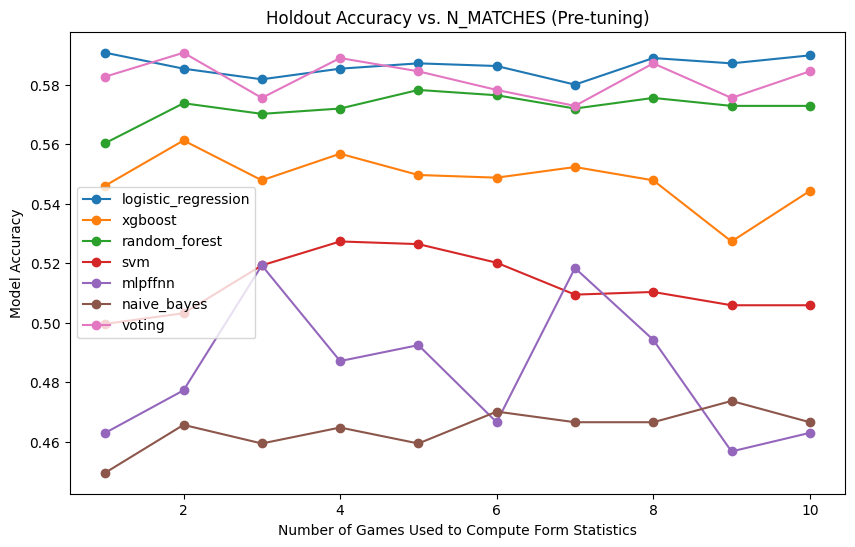

In [7]:
# Use consistent color scheme
colors = plt.cm.tab10

plt.figure(figsize=(10, 6))

for idx, model_type in enumerate(Models):
    plt.plot(n_to_test, pre_tuned_accuracies[model_type], 'o-', color=colors(idx), label=model_type.name.lower())
    print(f'Highest testing accuracy for {model_type.name} was {max(pre_tuned_accuracies[model_type]):.5f}')

plt.xlabel('Number of Games Used to Compute Form Statistics')
plt.ylabel('Model Accuracy')
plt.title(f'Holdout Accuracy vs. N_MATCHES (Pre-tuning)')
plt.legend()
plt.show()

Now let's plot how the accuracies of the post-tuned models look vs. N_MATCHES.

Highest testing accuracy for LOGISTIC_REGRESSION was 0.59071
Highest testing accuracy for XGBOOST was 0.57909
Highest testing accuracy for RANDOM_FOREST was 0.58624
Highest testing accuracy for SVM was 0.54424
Highest testing accuracy for MLPFFNN was 0.52011
Highest testing accuracy for NAIVE_BAYES was 0.47364
Highest testing accuracy for VOTING was 0.59249


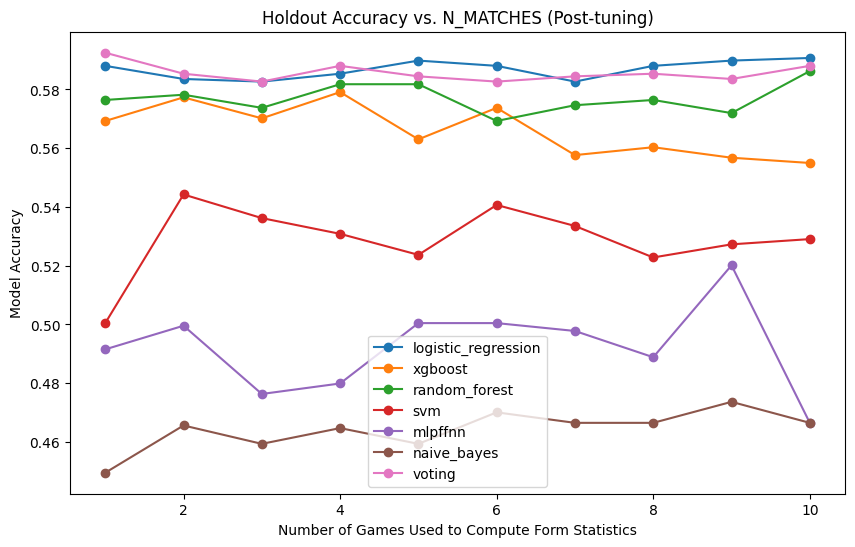

In [8]:
plt.figure(figsize=(10, 6))

for idx, model_type in enumerate(Models):
    plt.plot(n_to_test, tuned_accuracies[model_type], 'o-', color=colors(idx), label=model_type.name.lower())
    print(f'Highest testing accuracy for {model_type.name} was {max(tuned_accuracies[model_type]):.5f}')

plt.xlabel('Number of Games Used to Compute Form Statistics')
plt.ylabel('Model Accuracy')
plt.title(f'Holdout Accuracy vs. N_MATCHES (Post-tuning)')
plt.legend()
plt.show()

Finally, let's overlap these to see exactly how tuning impacted our model accuracies.

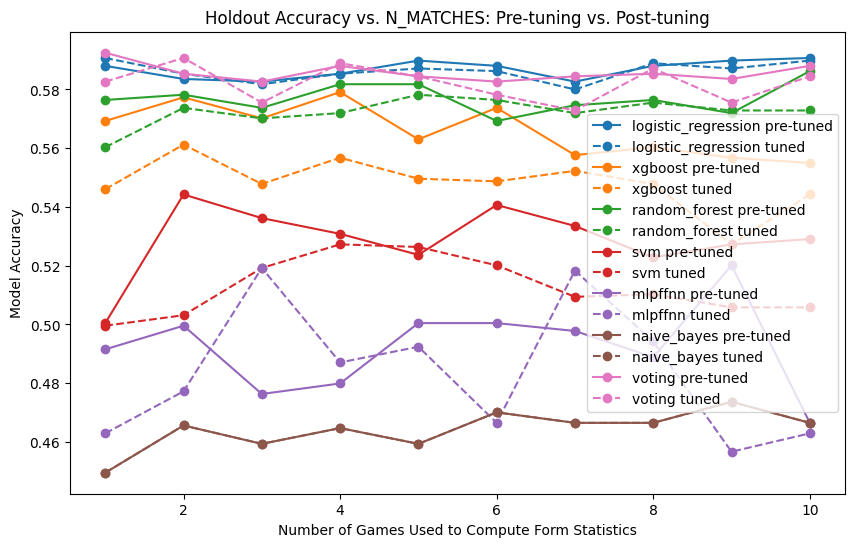

In [9]:
plt.figure(figsize=(10, 6))

for idx, model_type in enumerate(Models):
    plt.plot(n_to_test, tuned_accuracies[model_type], 'o-', color=colors(idx), label=f'{model_type.name.lower()} pre-tuned')
    plt.plot(n_to_test, pre_tuned_accuracies[model_type], 'o--', color=colors(idx), label=f'{model_type.name.lower()} tuned')

plt.xlabel('Number of Games Used to Compute Form Statistics')
plt.ylabel('Model Accuracy')
plt.title(f'Holdout Accuracy vs. N_MATCHES: Pre-tuning vs. Post-tuning')
plt.legend()
plt.show()

Generally speaking, it appears that tuning has improved the accuracy of each model, since the solid lines are more or less above the dashed lines. For some models, like XGBoost, tuning seems to have significantly increased the accuracy, whereas for models like MLP FFN, the impact is more random.

## Conclusion
Here are the following models ranked from highest to least testing accuracy:
1. Voting Ensemble: 0.59249
2. Logistic Regression: 0.59071
3. Random Forest: 0.58624
4. XGBoost: 0.57909
5. Support Vector Machine: 0.54424
6. Multilayer Perceptron FFN: 0.52011
7. Naive Bayes: 0.47364
It's worth noting that the voting ensemble method combining the 3 most performant individual models (Logistic Regression, Random Forest, and XGBoost) had the best holdout accuracy.